# Energy resolution after  delta-z effect correction


### Nov 2020, JAH

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt

to_df = pd.DataFrame.from_records

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.hfit         as hfit

import bes.bes           as bes

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Wed Nov 11 20:06:00 2020


In [5]:
datadir    = f"/data_extra2/jrenner/analysis/NEW"
run_number = str(8180)
filename   = datadir + f'/{run_number}' + f'/hdf5/cdst/trigger2/cdst_combined_{run_number}' + '.h5'
print('data filename: ', filename)

data filename:  /data_extra2/jrenner/analysis/NEW/8180/hdf5/cdst/trigger2/cdst_combined_8180.h5


In [6]:
dfe, dfs, dft = bes.load_dfs(filename)

/data_extra2/jrenner/analysis/NEW/8180/hdf5/cdst/trigger2/cdst_combined_8180.h5 (File) ''
Last modif.: 'Thu Nov  5 01:57:32 2020'
Object Tree: 
/ (RootGroup) ''
/DST (Group) ''
/DST/Events (Table(563388,), shuffle, zlib(4)) 'KDST Events'
/Summary (Group) ''
/Summary/Events (Table(443499,), shuffle, zlib(4)) 'Event summary information'
/Tracking (Group) ''
/Tracking/Tracks (Table(539115,), shuffle, zlib(4)) 'Track information'



In [7]:
dfe = to_df(f.root.DST.Events.read())
dfs = to_df(f.root.Summary.Events.read())
dft = to_df(f.root.Tracking.Tracks.read())

In [8]:
class Selections(dict):
    
    def logical_and(self, *names):
        
        assert len(names) >= 2
        name0, name1 = names[0], names[1]
        sel = self[name0] & self[name1]
        
        for name in names[2:]:
            sel = sel & self[name]
            
        return sel

### correct energy by delta-z

In [9]:
dft['dz_track'] = dft['z_max'] - dft['z_min']
dft['enecor']   = dft['energy']/(1 - 2.76e-4 * dft['dz_track'])

In [10]:
print(list(dft.columns))

['event', 'trackID', 'energy', 'length', 'numb_of_voxels', 'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min', 'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave', 'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x', 'vox_size_y', 'vox_size_z', 'dz_track', 'enecor']


### selections and ranges

In [11]:
ranges = {'ene': (0., 3.), 'ene_cs': (0.65, 0.71), 'ene_ds': (1.55, 1.75), 'ene_ph': (2.5, 3.)} 

tsels = Selections()
tsels['onetrack']      = dft.numb_of_tracks == 1

tsels['fidutial_zmin'] = dft.z_min > 50.
tsels['fidutial_zmax'] = dft.z_max < 500.   
tsels['fidutial_rmax'] = dft.r_max < 180.
tsels['fidutial']      = tsels.logical_and('fidutial_zmin', 'fidutial_zmax', 'fidutial_rmax')

tsels['dz_cs'] = (dft.dz_track >  8.) & (dft.dz_track <  32.)
tsels['dz_ds'] = (dft.dz_track > 24.) & (dft.dz_track <  72.)
tsels['dz_ph'] = (dft.dz_track > 35.) & (dft.dz_track < 130.)

### Energy 

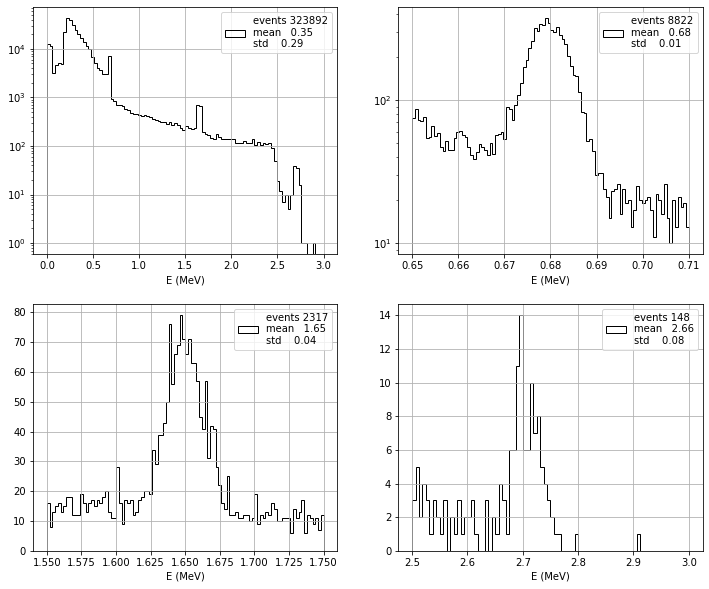

In [12]:
def plt_energies(enes, sel = None):

    xsel = sel if sel is not None else enes > np.min(enes)

    subplot = pltext.canvas(4, 2)
    subplot(1)
    pltext.hist(enes[xsel], 100, range = ranges['ene'], ylog = True, xylabels = 'E (MeV)'); 
    subplot(2)
    pltext.hist(enes[xsel], 100, range = ranges['ene_cs'], ylog = True, xylabels = 'E (MeV)');
    subplot(3)
    pltext.hist(enes[xsel], 100, range = ranges['ene_ds'], xylabels = 'E (MeV)');
    subplot(4)
    pltext.hist(enes[xsel], 80, range  = ranges['ene_ph'], xylabels = 'E (MeV)');

plt_energies(dft.energy, tsels['fidutial'])

In [13]:
def plt_energies_fit(enes, ranges, parameters, selections = None):

    nsize = len(ranges)
    subplot = pltext.canvas(nsize)
    
    selections = selections if selections is not None else nsize * [enes > np.min(enes)]
    
    epars = []
    for i in range(nsize):
        subplot(i + 1)
        xsel, xpars   = selections[i] & ut.in_range(enes, ranges[i]), parameters[i]
        pars, parscov = pltext.hfit(enes[xsel], 'gausline', xpars, formate = '7.4f');
        epars.append((pars, parscov))
 
    dpars = {}
    dpars['energy'] = [ipars[1] for ipars, iparscov in epars]
    dpars['sigma']  = [ipars[2] for ipars, iparscov in epars]
    dpars['usigma'] = [iparscov[2] for ipars, iparscov in epars]
    dpars['R']      = [235. * ipars[2]/ipars[1] for ipars, iparscov in epars]
    dpars['uR']     = [235. * iparscov[2]/ipars[1] for ipars, iparscov in epars]


    dferes = pd.DataFrame(dpars)
    
    return dferes

fidutial cuts
energy 
      energy     sigma    usigma         R        uR
0  0.679806  0.004285  0.000055  1.481216  0.019165
1  1.649734  0.013250  0.000529  1.887365  0.075331
2  2.702826  0.026338  0.001727  2.290006  0.150188
fidutial cuts


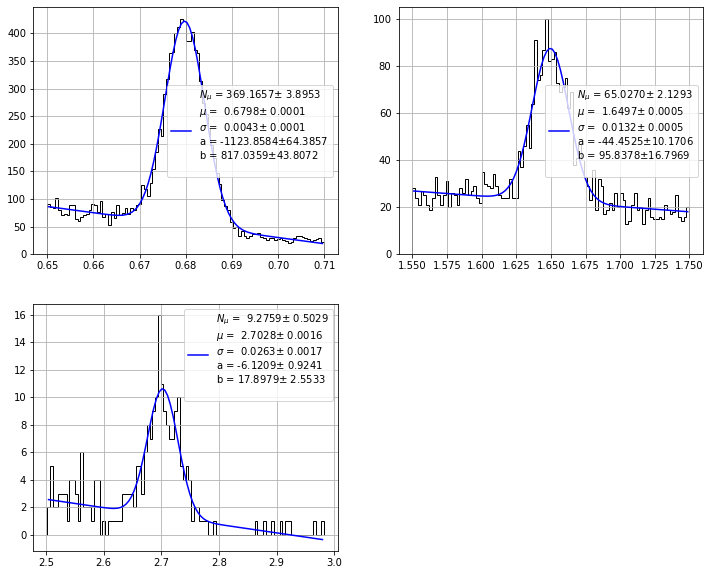

In [14]:
xsel = tsels['onetrack']
xranges = (ranges['ene_cs'], ranges['ene_ds'], ranges['ene_ph'])
xpars0  = ((65.,  0.7, 0.013,  553., 1.9), (65.,  1.65, 0.013,  553., 1.9), (10.,  2.7, 0.013,  10., 1.))
dfenes0 = plt_energies_fit(dft.energy, xranges, xpars0, 3*[xsel])
print('fidutial cuts')
print('energy \n', dfenes0)
print('fidutial cuts')

fidutial cuts
correced by dz-effect energy 
      energy     sigma    usigma         R        uR
0  0.683578  0.003640  0.000055  1.251495  0.018935
1  1.671289  0.008257  0.000196  1.161046  0.027559
2  2.773130  0.016885  0.001191  1.430848  0.100936


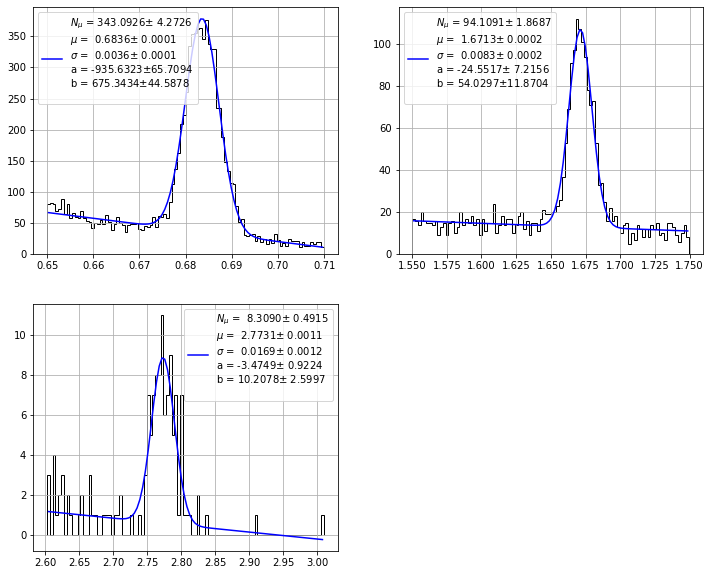

In [15]:
xranges = [ranges['ene_cs'], ranges['ene_ds'], (2.6, 3.2)]
xpars0  = ((65.,  0.7, 0.01,  553., 1.9), (65.,  1.65, 0.013,  553., 1.9), (10.,  2.75, 0.01,  -5, 13.))
dfenes1 = plt_energies_fit(dft.enecor, xranges, xpars0, 3*[tsels['fidutial']])
print('fidutial cuts')
print('correced by dz-effect energy \n', dfenes1)

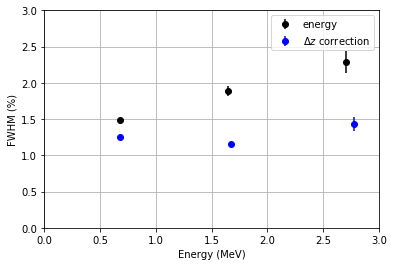

In [16]:
plt.errorbar(dfenes0.energy, dfenes0.R, yerr = dfenes0.uR, 
             marker = 'o',  ls = '', label = 'energy');
plt.errorbar(dfenes1.energy, dfenes1.R, yerr = dfenes1.uR, 
             marker = 'o', ls = '', label = r'$\Delta z$ correction')
plt.grid(); plt.xlim((0., 3.)); plt.ylim(0., 3.)
plt.xlabel('Energy (MeV)'); plt.legend(); plt.ylabel('FWHM (%)');

### extra selection in $\Delta z$ range

fidutial cuts with delta-z range
correced by dz-effect energy 
      energy     sigma    usigma         R        uR
0  0.683554  0.003597  0.000059  1.236655  0.020197
1  1.670737  0.007683  0.000177  1.080631  0.024893
2  2.772624  0.018159  0.001994  1.539129  0.168993


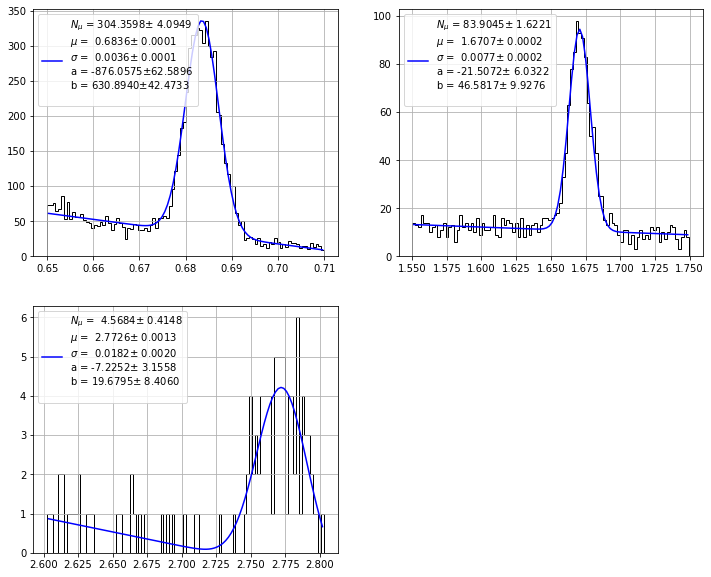

In [17]:
xsels = (tsels.logical_and('fidutial', 'dz_cs'), 
         tsels.logical_and('fidutial', 'dz_ds'), 
         tsels.logical_and('fidutial', 'dz_ph'))
xranges = [ranges['ene_cs'], ranges['ene_ds'], (2.6, 3.2)]
xpars0  = ((65.,  0.7, 0.01,  553., 1.9), (65.,  1.65, 0.013,  553., 1.9), (10.,  2.75, 0.01,  -5, 13.))
dfenes1 = plt_energies_fit(dft.enecor, xranges, xpars0, xsels)
print('fidutial cuts with delta-z range')
print('correced by dz-effect energy \n', dfenes1)

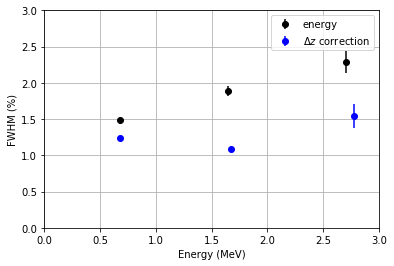

In [18]:
plt.errorbar(dfenes0.energy, dfenes0.R, yerr = dfenes0.uR, 
             marker = 'o',  ls = '', label = 'energy');
plt.errorbar(dfenes1.energy, dfenes1.R, yerr = dfenes1.uR, 
             marker = 'o', ls = '', label = r'$\Delta z$ correction')
plt.grid(); plt.xlim((0., 3.)); plt.ylim(0., 3.)
plt.xlabel('Energy (MeV)'); plt.legend(); plt.ylabel('FWHM (%)');